Goal: use a decision tree model to predict the relaxed energy of catalysts. 

Pipeline:
- data inspection & cleaning
- hot encoding (not all features are numeric) 
- correlation analysis (feature reduction) ??
- principal component analysis (for visualization) ??
- cross validation
- hyperparameter tuning & model selection
- final model evaluation
- feature importance
- exploitation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt


df_h = pd.read_csv('training_SAMPLE_h_all_featurized.csv')
df_no_ads = pd.read_csv('training_SAMPLE_no_ads_all_featurized.csv')

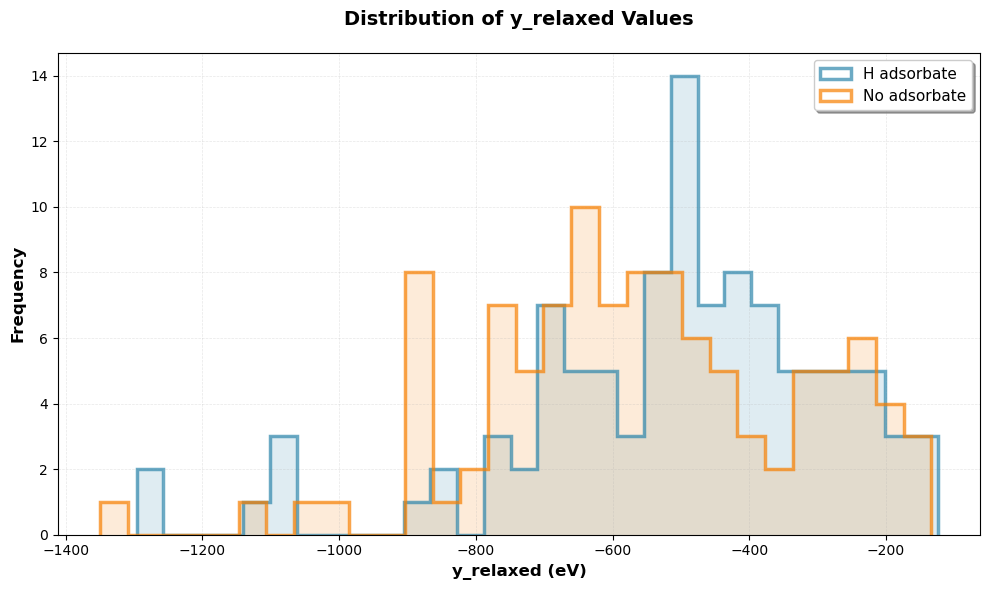

In [3]:
# Create figure with better size and resolution
fig, ax = plt.subplots(figsize=(10, 6), dpi=100)

# Plot histograms as step curves (no overlap issues)
ax.hist(df_h['y_relaxed'], bins=30, alpha=0.7, color='#2E86AB', label='H adsorbate', histtype='step', linewidth=2.5)
ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.7, color='#F77F00', label='No adsorbate', histtype='step', linewidth=2.5)

# Optional: add fill under the lines for better visibility
ax.hist(df_h['y_relaxed'], bins=30, alpha=0.15, color='#2E86AB', histtype='stepfilled')
ax.hist(df_no_ads['y_relaxed'], bins=30, alpha=0.15, color='#F77F00', histtype='stepfilled')

ax.set_xlabel('y_relaxed (eV)', fontsize=12, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=12, fontweight='bold')
ax.set_title('Distribution of y_relaxed Values', fontsize=14, fontweight='bold', pad=20)

ax.legend(loc='upper right', frameon=True, shadow=True, fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=10)

plt.tight_layout()
plt.show()

In [43]:
print(f"columns in h-ads dataset before: {df_h.shape[1]}")
print(f"columns in no-ads dataset before: {df_no_ads.shape[1]}")
print(f"rows in h-ads dataset before: {df_h.shape[0]}")
print(f"rows in no-ads dataset before: {df_no_ads.shape[0]}")

# get features (columns) with all NaN values
nan_cols_h = df_h.columns[df_h.isna().all()].tolist()
nan_cols_no_ads = df_no_ads.columns[df_no_ads.isna().all()].tolist()

# get features with all 0 values
h_num_cols = df_h.select_dtypes(include='number')
h_zero_cols = h_num_cols.columns[h_num_cols.eq(0).all()]

no_ads_num_cols = df_no_ads.select_dtypes(include='number')
no_ads_zero_cols = no_ads_num_cols.columns[no_ads_num_cols.eq(0).all()]

print("----")
print("Columns with all NaN values in h-ads dataset:", nan_cols_h)
print("Columns with all NaN values in no-ads dataset:", nan_cols_no_ads)
print("Columns with all 0 values in h-ads dataset:", h_zero_cols)
print("Columns with all 0 values in no-ads dataset:", no_ads_zero_cols)

# drop NaN columns
df_h_clean_col = df_h.drop(columns=nan_cols_h)
df_no_ads_clean_col = df_no_ads.drop(columns=nan_cols_no_ads)

# drop all-0 columns
df_h_clean_col = df_h_clean_col.drop(columns=h_zero_cols)
df_no_ads_clean_col = df_no_ads_clean_col.drop(columns=no_ads_zero_cols)

# drop rows with no structure data
df_h_clean = df_h_clean_col.dropna(subset=['structure'])
df_no_ads_clean = df_no_ads_clean_col.dropna(subset=['structure'])

print("----")
print(f"columns in h-ads dataset after cleaning: {df_h_clean.shape[1]}")
print(f"columns in no-ads dataset after cleaning: {df_no_ads_clean.shape[1]}")

print(f"rows in h-ads dataset after cleaning: {df_h_clean.shape[0]}")
print(f"rows in no-ads dataset after cleaning: {df_no_ads_clean.shape[0]}")

columns in h-ads dataset before: 380
columns in no-ads dataset before: 386
rows in h-ads dataset before: 104
rows in no-ads dataset before: 106
----
Columns with all NaN values in h-ads dataset: []
Columns with all NaN values in no-ads dataset: []
Columns with all 0 values in h-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData mode NfValence', 'MagpieData minimum NsUnfilled',
       'MagpieData minimum NdUnfilled', 'MagpieData mode NdUnfilled',
       'MagpieData minimum NfUnfilled', 'MagpieData mode NfUnfilled',
       'MagpieData minimum GSbandgap', 'MagpieData mode GSbandgap',
       'MagpieData minimum GSmagmom', 'MagpieData mode GSmagmom'],
      dtype='object')
Columns with all 0 values in no-ads dataset: Index(['MagpieData minimum NdValence', 'MagpieData minimum NfValence',
       'MagpieData mode NfValence', 'MagpieData minimum NsUnfilled',
       'MagpieData minimum NdUnfilled', 'MagpieData mode NdUnfilled',
       'MagpieDa

In [44]:
# separate dataframe into features, identifiers, and target
h_id = df_h_clean[['bulk_id', 'bulk_symbols', 'structure']]
h_y = df_h_clean['y_relaxed']
h_X = df_h_clean.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])

no_ads_id = df_no_ads_clean[['bulk_id', 'bulk_symbols', 'structure']]
no_ads_y = df_no_ads_clean['y_relaxed']
no_ads_X = df_no_ads_clean.drop(columns=['bulk_id', 'bulk_symbols', 'y_relaxed', 'structure'])

## Hot encode

need to do this for correlation analysis. Otherwise, decision tree models do not need hot-encoded datasets.

In [45]:
encoded_h_X = pd.get_dummies(h_X)
encoded_no_ads_X = pd.get_dummies(no_ads_X)

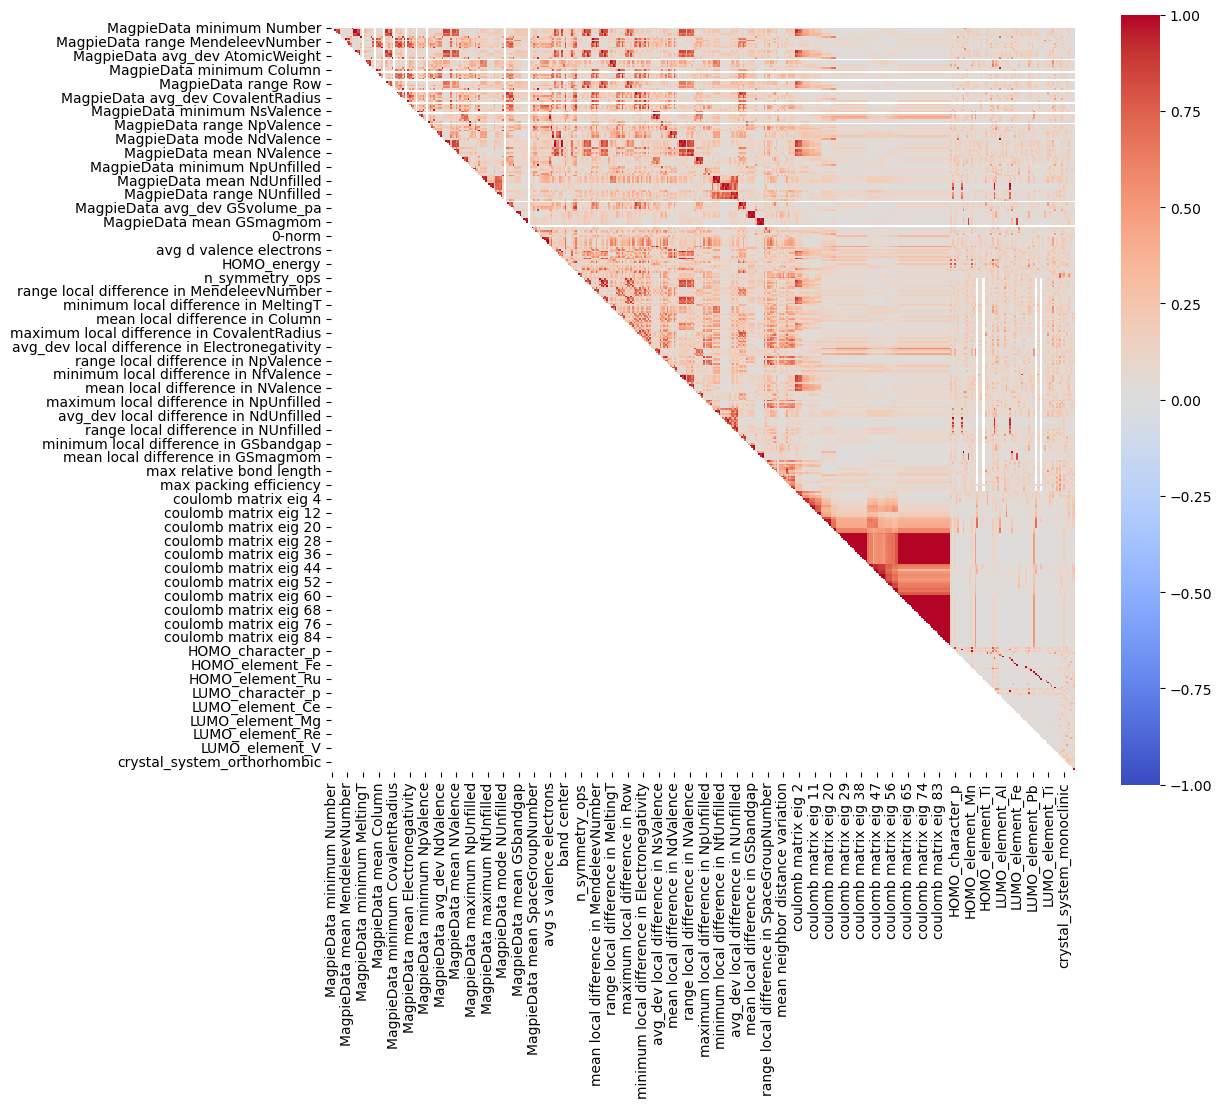

In [46]:
import seaborn as sns
import numpy as np

h_corr_mat = encoded_h_X.corr().abs()
upper_tri = h_corr_mat.where(np.triu(np.ones(h_corr_mat.shape), k=1).astype(bool)) 

plt.figure(figsize=(12, 10))
sns.heatmap(upper_tri, cmap='coolwarm', center=0, vmin=-1, vmax=1, square=True)
plt.show()

*TO-DO:*

find a way to drop highly correlated features

In [47]:
high_corr_pairs = []
for column in upper_tri.columns:
    for row in upper_tri.index:
        if abs(upper_tri.loc[row, column]) > 0.9:
            high_corr_pairs.append((row, column, upper_tri.loc[row, column]))

high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature 1", "Feature 2", "Correlation"])
high_corr_df = high_corr_df.sort_values(by="Correlation", key=abs, ascending=False)

high_corr_df

,Feature 1,Feature 2,Correlation
911,coulomb matrix eig 60,coulomb matrix eig 72,1.000000
834,coulomb matrix eig 67,coulomb matrix eig 69,1.000000
1595,MagpieData maximum NfUnfilled,LUMO_character_f,1.000000
1596,MagpieData range NfUnfilled,LUMO_character_f,1.000000
1606,MagpieData maximum NfUnfilled,LUMO_element_Ce,1.000000
...,...,...,...
95,MagpieData maximum CovalentRadius,MagpieData range GSvolume_pa,0.900700
93,MagpieData maximum CovalentRadius,MagpieData maximum GSvolume_pa,0.900700
96,MagpieData range CovalentRadius,MagpieData range GSvolume_pa,0.900700
94,MagpieData range CovalentRadius,MagpieData maximum GSvolume_pa,0.900700


# Regression

Since some structural features are non-numeric, we need to preprocess those columns for regression.

In [57]:
is_obj = h_X.dtypes == 'object'

# get the part of the dataframe that is obj data type (which is a string)
h_X_obj = h_X.loc[:, is_obj]

# hot-encodes the categorical structure features.
# this code is generated by ChatGPT and I am not sure exactly how it works
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline

# OneHotCoder transforms each categorical feature with (n_categories) possible values
# into n_categories binary features.
preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), h_X_obj.columns)
    ],
    remainder='passthrough' # columns not specified in transformers will be untouched.
    # since we are only passing in the categorical columns, this shouldn't matter
)

model = Pipeline([
    ('preprocess', preprocess),
    ('regression', DecisionTreeRegressor())])

In [56]:
from sklearn.model_selection import train_test_split


h_X_train, h_X_test, h_y_train, h_y_test = train_test_split(h_X, h_y, test_size=0.4, random_state=1065)

model.fit(h_X_train, h_y_train)
model.predict(h_X_test)

ValueError: Found unknown categories ['Os', 'Cr', 'Ru', 'Pt', 'Ta'] in column 1 during transform